In [17]:
import pandas as pd
import numpy as np
from scipy.stats import randint
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from time import time

In [18]:
bbc_data = pd.read_csv("../data/clean_bbc_classification.csv")
sarc_data = pd.read_csv("../data/clean_sarcasm_classification.csv")

### RFC on BBC News Classification
#### Simple RFC

In [25]:
X = bbc_data['text']
y = bbc_data['label_ids']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=123)

vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

In [26]:
bbc_data[['labels', 'label_ids']].drop_duplicates()

,labels,label_ids
0,entertainment,0
386,business,1
896,sport,2
1407,politics,3
1824,tech,4


In [27]:
t0 = time()
rfc = RandomForestClassifier(n_jobs=-1)
rfc.fit(X_train, y_train)
preds = rfc.predict(X_test)
print("Simple Random Forest Classifier")
print(classification_report(y_test, preds))
t1 = time()
runtime_rfc_simple = round(t1-t0, 2)
print(f"Runtime: {runtime_rfc_simple} seconds")
performance_rfc_simple = classification_report(y_test, preds, output_dict=True)

Simple Random Forest Classifier
              precision    recall  f1-score   support

           0       0.95      0.95      0.95        65
           1       0.95      0.97      0.96       103
           2       0.99      1.00      1.00       114
           3       0.99      0.95      0.97        88
           4       0.99      0.99      0.99        75

    accuracy                           0.98       445
   macro avg       0.97      0.97      0.97       445
weighted avg       0.98      0.98      0.98       445

Runtime: 3.13 seconds


In [31]:
importances_df = pd.DataFrame({'Feature': vectorizer.get_feature_names_out(), 'Importance': rfc.feature_importances_}).sort_values(by='Importance', ascending=False)
importances_df

,Feature,Importance
6372,company,0.009735
18468,party,0.008779
11500,government,0.007760
11017,game,0.007230
16790,mr,0.006964
...,...,...
11061,garish,0.000000
11060,gargantuan,0.000000
11059,garfunkel,0.000000
11056,gardner,0.000000


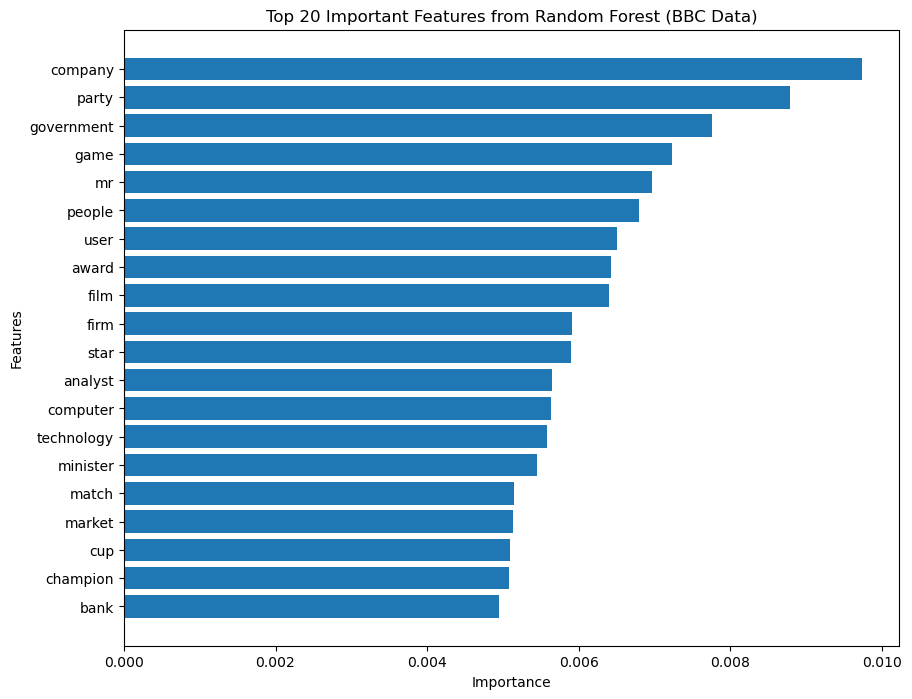

In [41]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))  # Adjust the size to fit your needs
plt.barh(importances_df['Feature'][:20], importances_df['Importance'][:20])  # Top 20 features
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Top 20 Important Features from Random Forest (BBC Data)')
plt.gca().invert_yaxis()

In [38]:
data = pd.read_csv("../data/evaluation_data.csv")
data = pd.concat([data,
                  pd.DataFrame({
                      'Model': ['Random Forest'],
                      'Runtime': [runtime_rfc_simple],
                      'Accuracy': [performance_rfc_simple['accuracy']],
                      'F1': [performance_rfc_simple['weighted avg']['f1-score']],
                      'data': ['bbc news']
                  })], ignore_index=True)
data

,Model,Runtime,Accuracy,F1,data
0,Decision Tree,0.70,0.840449,0.840706,bbc news
1,Decision Tree fine-tuned,14.45,0.817978,0.822761,bbc news
2,Decision Tree,11.28,0.725891,0.725137,sarcasm detection
3,Decision Tree fine-tuned,58.69,0.629804,0.590813,sarcasm detection
4,Random Forest,3.13,0.975281,0.975275,bbc news


**Given stunning results on simple Random Forest, we will not fine-tune the model on this dataset**

### RFC on Sarcasm Detection
#### Simple RFC

In [39]:
sarc_data = sarc_data.dropna()
X = sarc_data['text']
y = sarc_data['is_sarcastic']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=123)

vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

In [40]:
t0 = time()
rfc = RandomForestClassifier(n_jobs=-1)
rfc.fit(X_train, y_train)
preds = rfc.predict(X_test)
print("Simple Random Forest Classifier")
print(classification_report(y_test, preds))
t1 = time()
runtime_rfc_simple = round(t1-t0, 2)
print(f"Runtime: {runtime_rfc_simple} seconds")
performance_rfc_simple = classification_report(y_test, preds, output_dict=True)

Simple Random Forest Classifier
              precision    recall  f1-score   support

           0       0.74      0.85      0.79      2978
           1       0.80      0.67      0.73      2746

    accuracy                           0.76      5724
   macro avg       0.77      0.76      0.76      5724
weighted avg       0.77      0.76      0.76      5724

Runtime: 63.46 seconds


#### Fine-tuned RFC

In [44]:
# t0 = time()
# rfc = RandomForestClassifier(n_jobs=-1)
# param_dist = {
#     'n_estimators': [100, 200], 
#     'max_depth': [None, 10, 20],
#     'min_samples_split': randint(2, 11),
#     'min_samples_leaf': randint(1, 11),
#     'criterion': ['gini', 'entropy']
# }

# rnd_cv = RandomizedSearchCV(rfc, param_distributions=param_dist,
#                             n_iter=10, cv=3, scoring='accuracy', random_state=42, n_jobs=-1)
# rnd_cv.fit(X_train, y_train)
# print("Best parameters:", rnd_cv.best_params_)
# print("Best score:", rnd_cv.best_score_)
rfc = RandomForestClassifier(**rnd_cv.best_params_, n_jobs=-1)
rfc.fit(X_train, y_train)
preds = rfc.predict(X_test)
print("Fine-tuned Random Forest Classifier")
print(classification_report(y_test, preds))
t1 = time()
runtime_rfc_tuned = round(t1-t0, 2)
print(f"Runtime: {runtime_rfc_tuned} seconds")
performance_rfc_tuned = classification_report(y_test, preds, output_dict=True)


Fine-tuned Random Forest Classifier
              precision    recall  f1-score   support

           0       0.77      0.81      0.79      2978
           1       0.78      0.74      0.76      2746

    accuracy                           0.78      5724
   macro avg       0.78      0.78      0.78      5724
weighted avg       0.78      0.78      0.78      5724

Runtime: 465.43 seconds


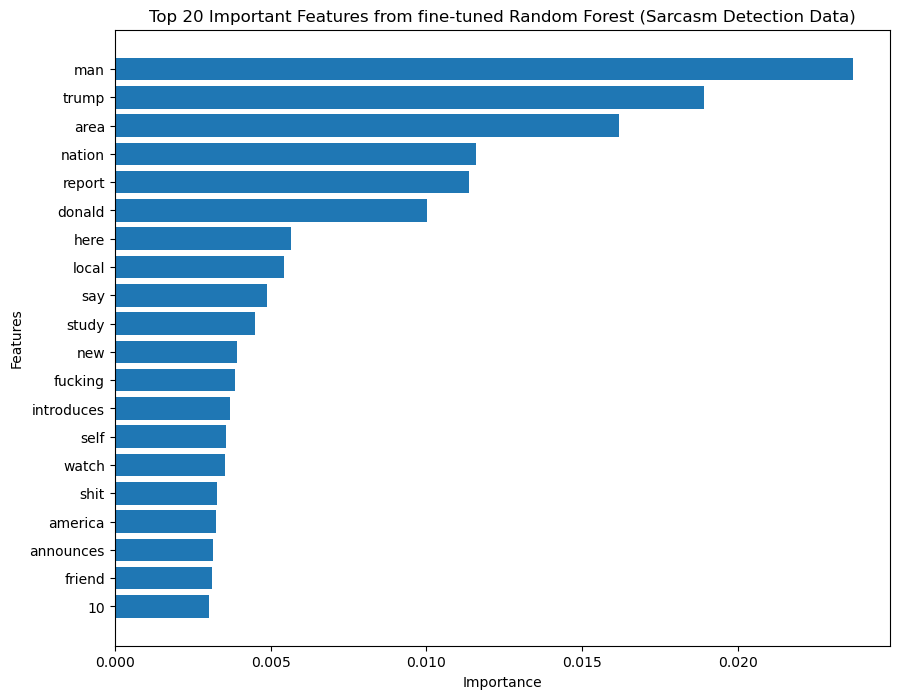

In [45]:
importances_df = pd.DataFrame({'Feature': vectorizer.get_feature_names_out(), 'Importance': rfc.feature_importances_}).sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10, 8))  # Adjust the size to fit your needs
plt.barh(importances_df['Feature'][:20], importances_df['Importance'][:20])  # Top 20 features
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Top 20 Important Features from fine-tuned Random Forest (Sarcasm Detection Data)')
plt.gca().invert_yaxis()

In [47]:
data = pd.concat([data,
                  pd.DataFrame({
                      'Model': ['Random Forest', 'Random Forest fine-tuned'],
                      'Runtime': [runtime_rfc_simple, runtime_rfc_tuned],
                      'Accuracy': [performance_rfc_simple['accuracy'], performance_rfc_tuned['accuracy']],
                      'F1': [performance_rfc_simple['weighted avg']['f1-score'], performance_rfc_tuned['weighted avg']['f1-score']],
                      'data': ['sarcasm detection', 'sarcasm detection']
                  })], ignore_index=True)
data

,Model,Runtime,Accuracy,F1,data
0,Decision Tree,0.70,0.840449,0.840706,bbc news
1,Decision Tree fine-tuned,14.45,0.817978,0.822761,bbc news
2,Decision Tree,11.28,0.725891,0.725137,sarcasm detection
3,Decision Tree fine-tuned,58.69,0.629804,0.590813,sarcasm detection
4,Random Forest,3.13,0.975281,0.975275,bbc news
5,Random Forest,63.46,0.763277,0.761070,sarcasm detection
6,Random Forest fine-tuned,465.43,0.776555,0.776098,sarcasm detection


In [48]:
data.to_csv("../data/evaluation_data_2.csv", index=False)